# Multi class image classification:

This notebook lists all the steps that you need to complete the complete this project. You will need to complete all the TODOs in this notebook as well as in the README and the two python scripts included with the starter code.


In [2]:
%%capture
!pip install smdebug
!pip install smdebug torch torchvision tqdm

In [3]:
import sagemaker
from sagemaker.debugger import (
    Rule,
    rule_configs, 
    ProfilerRule,
    DebuggerHookConfig,
    CollectionConfig,
    ProfilerConfig,
    FrameworkProfile
)
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot
import boto3
from sagemaker.tuner import CategoricalParameter, ContinuousParameter, HyperparameterTuner
from sagemaker.pytorch import PyTorch
from sagemaker import get_execution_role
from sagemaker.debugger import Rule, DebuggerHookConfig, TensorBoardOutputConfig, CollectionConfig, ProfilerRule, rule_configs
from sagemaker.debugger import ProfilerConfig, FrameworkProfile
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys
from smdebug.profiler.analysis.notebook_utils.training_job import TrainingJob
from smdebug.profiler.analysis.notebook_utils.timeline_charts import TimelineCharts
from smdebug import modes
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import IPython
conn = boto3.client('s3')


[2022-05-26 13:17:51.370 ip-172-16-91-132:17588 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None


## Dataset
TODO: Explain what dataset you are using for this project. Maybe even give a small overview of the classes, class distributions etc that can help anyone not familiar with the dataset get a better understand of it.

In [4]:
%%capture
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
!unzip dogImages.zip
!aws s3 cp dogImages s3://srs-udacity-aws-2022/project2/ --recursive

## Hyperparameter Tuning
**TODO:** This is the part where you will finetune a pretrained model with hyperparameter tuning. Remember that you have to tune a minimum of two hyperparameters. However you are encouraged to tune more. You are also encouraged to explain why you chose to tune those particular hyperparameters and the ranges.

**Note:** You will need to use the `hpo.py` script to perform hyperparameter tuning.

In [35]:
hyperparameter_ranges = {
    "lr": ContinuousParameter(0.0001, 0.1),
    "eps": ContinuousParameter(1e-9, 1e-8),
    "weight_decay": ContinuousParameter(1e-3, 1e-1),
    "batch_size": CategoricalParameter([ 64, 128]),
    "epochs": CategoricalParameter([ 5, 10, 15, 20]),
}
objective_metric_name = "average test loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "average test loss", "Regex": "Test loss: ([0-9\\.]+)"}]

In [40]:
estimator = PyTorch(
    entry_point="hpo.py",
    base_job_name='pytorch_dog_hpo',
    role=role,
    framework_version="1.4.0",
    instance_count=1,
    instance_type='ml.p3.2xlarge', 
    py_version='py3'
)

tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=4,
    max_parallel_jobs=1,
    objective_type=objective_type,
    early_stopping_type="Auto"
)

In [ ]:
%%time
tuner.fit({"training": "s3://srs-udacity-aws-2022/project2/"})

........................................................................................................

In [42]:
best_estimator=tuner.best_estimator()
best_estimator.hyperparameters()


2022-05-27 09:32:07 Starting - Preparing the instances for training
2022-05-27 09:32:07 Downloading - Downloading input data
2022-05-27 09:32:07 Training - Training image download completed. Training in progress.
2022-05-27 09:32:07 Uploading - Uploading generated training model
2022-05-27 09:32:07 Completed - Training job completed


{'_tuning_objective_metric': '"average test loss"',
 'batch_size': '"64"',
 'epochs': '"5"',
 'eps': '9.035130055020735e-09',
 'lr': '0.00010642806589020997',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"pytorch_dog_hpo-2022-05-27-09-18-44-379"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-628477620632/pytorch_dog_hpo-2022-05-27-09-18-44-379/source/sourcedir.tar.gz"',
 'weight_decay': '0.005363793838194886'}

In [43]:
best_hyperparameters={'batch_size': int(best_estimator.hyperparameters()['batch_size'].replace('"', "")),
                      'eps': best_estimator.hyperparameters()['eps'],
                      'lr': best_estimator.hyperparameters()['lr'],
                      'weight_decay': best_estimator.hyperparameters()['weight_decay'],}
best_hyperparameters

{'batch_size': 64,
 'eps': '9.035130055020735e-09',
 'lr': '0.00010642806589020997',
 'weight_decay': '0.005363793838194886'}

## Model Profiling and Debugging
TODO: Using the best hyperparameters, create and finetune a new model

**Note:** You will need to use the `train_model.py` script to perform model profiling and debugging.

In [45]:
rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
]

profiler_config = ProfilerConfig(system_monitor_interval_millis=500,
                                 framework_profile_params=FrameworkProfile(num_steps=10)
)

collection_configs=[CollectionConfig(name="CrossEntropyLoss_output_0",parameters={
    "include_regex": "CrossEntropyLoss_output_0", "train.save_interval": "10","eval.save_interval": "1"})]

debugger_config=DebuggerHookConfig( collection_configs=collection_configs )

In [51]:
%%time
estimator = PyTorch(
    entry_point="train_model.py",
    instance_count=1,
    instance_type="ml.p3.2xlarge",
    role=role,
    framework_version="1.4.0",
    py_version="py3",
    hyperparameters=best_hyperparameters,
    profiler_config=profiler_config, # include the profiler hook
    debugger_hook_config=debugger_config, # include the debugger hook
    rules=rules
)


estimator.fit({'training' : "s3://srs-udacity-aws-2022/project2/" },wait=True)

2022-05-27 15:34:43 Starting - Starting the training job...
2022-05-27 15:35:13 Starting - Preparing the instances for trainingVanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
ProfilerReport: InProgress
.........
2022-05-27 15:36:34 Downloading - Downloading input data.........
2022-05-27 15:38:15 Training - Downloading the training image......
2022-05-27 15:39:15 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-05-27 15:39:06,661 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2022-05-27 15:39:06,688 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-05-27 15:39:06,692 sagemaker_pytorch_container.training INFO     Invoking user training script.
2022-05-27 15:39:07,024 sagemaker-containers INFO     Module default

train loss: 293.0, acc: 7, best loss: 1000000.0
epoch time: 116.11905074119568
valid loss: 244.0, acc: 21, best loss: 244.0
epoch time: 137.59786987304688
Epoch: 2
train loss: 238.0, acc: 24, best loss: 244.0
epoch time: 85.38340401649475
valid loss: 180.0, acc: 32, best loss: 180.0
epoch time: 96.17540264129639
Testing Model
Test loss: 180.0
Test accuracy: 31.0
Saving Model
2022-05-27 15:43:21,594 sagemaker-containers INFO     Reporting training SUCCESS

2022-05-27 15:43:50 Uploading - Uploading generated training model
2022-05-27 15:43:50 Completed - Training job completed
Training seconds: 439
Billable seconds: 439
CPU times: user 1.25 s, sys: 37.7 ms, total: 1.29 s
Wall time: 9min 20s


In [53]:
job_name = estimator.latest_training_job.name
client = estimator.sagemaker_session.sagemaker_client
description = client.describe_training_job(TrainingJobName=estimator.latest_training_job.name)
print(f"Jobname: {job_name}")
print(f"Client: {client}")
print(f"Description: {description}")

Jobname: pytorch-training-2022-05-27-15-34-43-036
Client: <botocore.client.SageMaker object at 0x7fa76ffe6750>
Description: {'TrainingJobName': 'pytorch-training-2022-05-27-15-34-43-036', 'TrainingJobArn': 'arn:aws:sagemaker:us-east-1:628477620632:training-job/pytorch-training-2022-05-27-15-34-43-036', 'ModelArtifacts': {'S3ModelArtifacts': 's3://sagemaker-us-east-1-628477620632/pytorch-training-2022-05-27-15-34-43-036/output/model.tar.gz'}, 'TrainingJobStatus': 'Completed', 'SecondaryStatus': 'Completed', 'HyperParameters': {'batch_size': '64', 'eps': '"9.035130055020735e-09"', 'lr': '"0.00010642806589020997"', 'sagemaker_container_log_level': '20', 'sagemaker_job_name': '"pytorch-training-2022-05-27-15-34-43-036"', 'sagemaker_program': '"train_model.py"', 'sagemaker_region': '"us-east-1"', 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-628477620632/pytorch-training-2022-05-27-15-34-43-036/source/sourcedir.tar.gz"', 'weight_decay': '"0.005363793838194886"'}, 'AlgorithmSpecif

In [52]:
trial = create_trial(estimator.latest_job_debugger_artifacts_path())

[2022-05-27 18:32:18.398 ip-172-16-91-132:17588 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-628477620632/pytorch-training-2022-05-27-15-34-43-036/debug-output


[2022-05-27 18:33:10.402 ip-172-16-91-132:17588 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2022-05-27 18:33:11.424 ip-172-16-91-132:17588 INFO trial.py:210] Loaded all steps
loaded TRAIN data
loaded EVAL data
Completed TRAIN plot
Completed EVAL plot


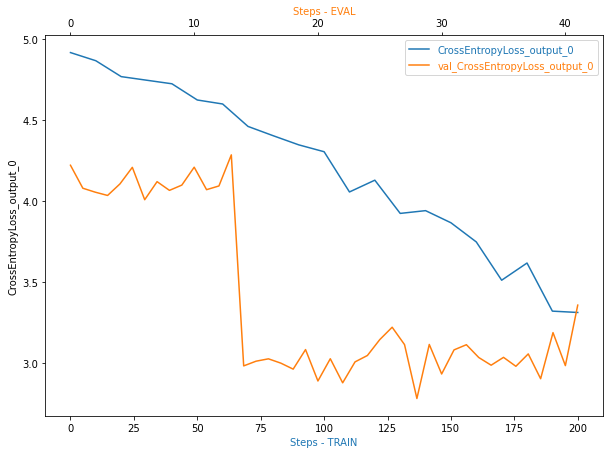

In [55]:
def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals

#plot tensor utility functions for plotting tensors
def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps - TRAIN")
    par.set_xlabel("Steps - EVAL")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("Completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("Completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)
    plt.show()
plot_tensor(trial, "CrossEntropyLoss_output_0")

**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

## Model Deploying

In [ ]:
# TODO: Deploy your model to an endpoint

predictor=estimator.deploy() # TODO: Add your deployment configuration like instance type and number of instances

In [ ]:
# TODO: Run an prediction on the endpoint

image = # TODO: Your code to load and preprocess image to send to endpoint for prediction
response = predictor.predict(image)

In [ ]:
# TODO: Remember to shutdown/delete your endpoint once your work is done
predictor.delete_endpoint()